In [38]:
#MLP 구현
import numpy as np
# 데이터 생성 --------------------------------
np.random.seed(seed=1) # 난수를 고정
N = 200 # 데이터의 수
K = 3 # 분포의 수
Y = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3] # X0의 범위, 표시용
X_range1 = [-3, 3] # X1의 범위, 표시용
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 각 분포에 대한 비율
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            Y[n, k] = 1
            break
    for k in range(2):
        X[n, k] = np.random.randn() * Sig[Y[n, :] == 1, k] + \
        Mu[Y[n, :] == 1, k]

In [39]:
# -------- 2 분류 데이터를 테스트 훈련 데이터로 분할
YestRatio = 0.5
X_n_training = int(N * YestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
Y_train = Y[:X_n_training, :]
Y_test = Y[X_n_training:, :]


# -------- 데이터를 'class_data.npz'에 저장
np.savez('class_data.npz', X_train=X_train, Y_train=Y_train,
         X_test=X_test, Y_test=Y_test,
         X_range0=X_range0, X_range1=X_range1)

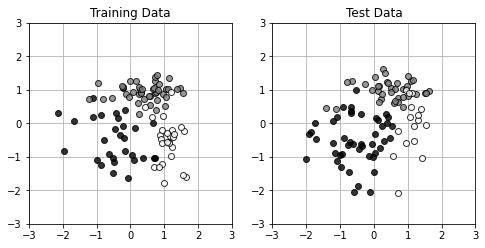

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline


# 데이터를 그리기 ------------------------------
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                 linestyle='none',
                 marker='o', markeredgecolor='black',
                 color=c[i], alpha=0.8)
    plt.grid(True)


# 메인 ------------------------------------
plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, Y_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1, 2, 2)
Show_data(X_test, Y_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

In [42]:
# 시그모이드 함수 ------------------------
def Sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


# 네트워크 ------------------------
def FNN(w, P, C, x):
    N, D = x.shape # 입력 차원
    w1 = w[:P * (D + 1)] # 중간층 뉴런의 가중치
    w1 = w1.reshape(P, (D + 1))
    w2 = w[P * (D + 1):] # 출력층 뉴런의 가중치
    w2 = w2.reshape((C, P + 1))
    zsum = np.zeros((N, P + 1)) # 중간층 뉴런의 입력 총합
    z = np.zeros((N, P + 1)) # 중간층 뉴런의 출력
    osum = np.zeros((N, C)) # 출력층 뉴런의 입력 총합
    o = np.zeros((N, C)) # 출력층 뉴런의 출력
    for n in range(N):
        # 중간층의 계산
        for j in range(P):
            zsum[n, j] = np.dot(w1[j, :], np.r_[x[n, :], 1]) # (A)
            z[n, j] = Sigmoid(zsum[n, j])
        # 출력층의 계산
        z[n, P] = 1 # 더미 뉴런
        for k in range(C):
            osum[n, k] = np.dot(w2[k, :], z[n, :])
            o[n, k] = Sigmoid(osum[n, k])
        
    return o, osum, z, zsum


# test ---
W = np.ones(15)
P = 2
C = 3
FNN(W, P, C, X_train[:2, :])

(array([[0.93686024, 0.93686024, 0.93686024],
        [0.81633727, 0.81633727, 0.81633727]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

In [43]:
# 평균 교차 엔트로피 오차 ---------
def MSE_FNN(w, P, C, x, t):
    N, D = x.shape
    o, _, _, _ = FNN(w, P, C, x)
    mse = np.sum((t.reshape(-1)-o.reshape(-1))**2) / N
    return mse


# test ---
W = np.ones(15)
P = 2
C = 3
MSE_FNN(W, P, C, X_train[:2, :], Y_train[:2, :])

1.5629729655354818

[ 0.02277293  0.07549159  0.00726891  0.0058113  -0.04554487 -0.04888018
  0.01392536  0.02306338  0.07127933 -0.01932577 -0.01936953 -0.09050691
  0.06486497  0.03982847  0.28700825]


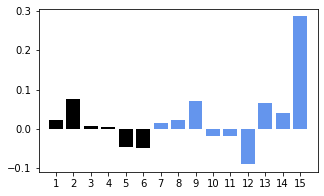

In [44]:
# - 수치 미분 ------------------
def dMSE_FNN_num(w, P, C, x, t):
    epsilon = 0.001
    dw = np.zeros_like(w)
    for iw in range(len(w)):
        w_modified = w.copy()
        w_modified[iw] = w[iw] - epsilon
        mse1 = MSE_FNN(w_modified, P, C, x, t)
        w_modified[iw] = w[iw] + epsilon
        mse2 = MSE_FNN(w_modified, P, C, x, t)
        dw[iw] = (mse2 - mse1) / (2 * epsilon)
    return dw


#--dW의 표시 ------------------
def Show_W(w, P):
    N = w.shape[0]
    plt.bar(range(1, P * 3 + 1), w[:P * 3], align="center", color='black')
    plt.bar(range(P * 3 + 1, N + 1), w[P * 3:],
            align="center", color='cornflowerblue')
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)


#-test----
P = 2
C = 3
nW = P * 3 + C * (P + 1)
np.random.seed(1)
W = np.random.normal(0, 1, nW)
dW = dMSE_FNN_num(W, P, C, X_train[:2, :], Y_train[:2, :])
print(dW)
plt.figure(1, figsize=(5, 3))
Show_W(dW, P)
plt.show()

In [45]:
import time

# 수치 미분을 사용한 구배법 -------
def Fit_FNN_num(w_init, P, C, x_train, t_train, x_test, t_test, n, alpha):
    wt = w_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    w_hist = np.zeros((n, len(w_init)))
    epsilon = 0.001
    for i in range(n): # (A)
        wt = wt - alpha * dMSE_FNN_num(wt, P, C, x_train, t_train)
        err_train[i] = MSE_FNN(wt, P, C, x_train, t_train)
        err_test[i] = MSE_FNN(wt, P, C, x_test, t_test)
        w_hist[i, :] = wt
        if i % 50 == 0:
            print(f"loss:{err_train[i]: > 7f} [{i:>5d}/{n: >5d}]")
    return wt, w_hist, err_train, err_test


# 메인 ---------------------------
startYime = time.time()
P = 2
C = 3
np.random.seed(1)
W_init = np.random.normal(0, 0.01, P * 3 + C * (P + 1))
N_step = 1000 # (B) 학습 단계
alpha = 0.5
W, W_hist, Err_train, Err_test = Fit_FNN_num(
    W_init, P, C, X_train, Y_train, X_test, Y_test, N_step, alpha)
calculation_time = time.time() - startYime
print("Calculation time:{0:.3f} sec".format(calculation_time))

loss: 0.733093 [    0/ 2000]
loss: 0.644023 [   50/ 2000]
loss: 0.616431 [  100/ 2000]
loss: 0.537110 [  150/ 2000]
loss: 0.459546 [  200/ 2000]
loss: 0.415327 [  250/ 2000]
loss: 0.391614 [  300/ 2000]
loss: 0.378083 [  350/ 2000]
loss: 0.369653 [  400/ 2000]
loss: 0.363846 [  450/ 2000]
loss: 0.359324 [  500/ 2000]
loss: 0.355182 [  550/ 2000]
loss: 0.350541 [  600/ 2000]
loss: 0.344165 [  650/ 2000]
loss: 0.333885 [  700/ 2000]
loss: 0.315849 [  750/ 2000]
loss: 0.285885 [  800/ 2000]
loss: 0.251074 [  850/ 2000]
loss: 0.224260 [  900/ 2000]
loss: 0.205412 [  950/ 2000]
loss: 0.191994 [ 1000/ 2000]
loss: 0.181990 [ 1050/ 2000]
loss: 0.174200 [ 1100/ 2000]
loss: 0.167941 [ 1150/ 2000]
loss: 0.162799 [ 1200/ 2000]
loss: 0.158503 [ 1250/ 2000]
loss: 0.154868 [ 1300/ 2000]
loss: 0.151760 [ 1350/ 2000]
loss: 0.149079 [ 1400/ 2000]
loss: 0.146749 [ 1450/ 2000]
loss: 0.144711 [ 1500/ 2000]
loss: 0.142918 [ 1550/ 2000]
loss: 0.141331 [ 1600/ 2000]
loss: 0.139921 [ 1650/ 2000]
loss: 0.138660

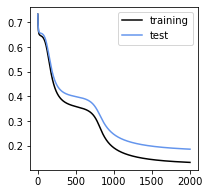

In [30]:
# 학습 오차의 표시 ---------------------------
plt.figure(1, figsize=(3, 3))
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label ='test')
plt.legend()
plt.show()

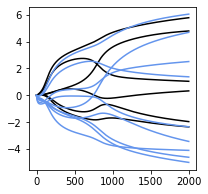

In [31]:
# 가중치의 시간 변화의 표시 ---------------------------
plt.figure(1, figsize=(3, 3))
plt.plot(W_hist[:, :P * 3], 'black')
plt.plot(W_hist[:, P * 3:], 'cornflowerblue')
plt.show()

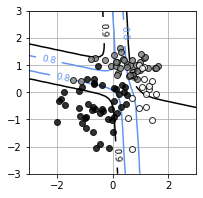

In [33]:
# 경계선 표시 함수 --------------------------
def show_FNN(w, P, C):
    xn = 60 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, (xn * xn, 1)), np.reshape(xx1, (xn * xn, 1))]
    o, _, _, _ = FNN(w, P, C, x)
    plt.figure(1, figsize=(4, 4))
    for k in range(C):
        f = o[:, k]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9],
                           colors=['cornflowerblue', 'black'])
        cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    
    
# 경계선 표시 --------------------------
plt.figure(1, figsize=(3, 3))
Show_data(X_test, Y_test)
show_FNN(W, P, C)
plt.show()

analytical dW
[ 0.01138647  0.0377458   0.00363445  0.00290565 -0.02277243 -0.02444009
  0.00696268  0.01153169  0.03563968 -0.00966288 -0.00968476 -0.04525346
  0.03243248  0.01991424  0.14350414]
numerical dW
[ 0.02277293  0.07549159  0.00726891  0.0058113  -0.04554487 -0.04888018
  0.01392536  0.02306338  0.07127933 -0.01932577 -0.01936953 -0.09050691
  0.06486497  0.03982847  0.28700825]


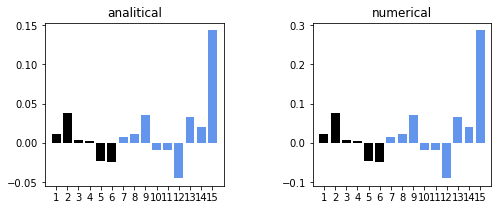

In [37]:
# -- 해석적 미분 -----------------------------------
def dMSE_FNN(w, P, C, x, t):
    N, D = x.shape
    # w을 w1와 w2로 되돌림
    w1 = w[:P * (D + 1)]
    w1 = w1.reshape(P, (D + 1))
    w2 = w[P * (D + 1):]
    w2 = w2.reshape((C, P + 1))
    # ① x를 입력하여 o를 얻음
    o, osum, z, zsum = FNN(w, P, C, x)
    # 출력 변수의 준비
    dw = np.zeros_like(w)
    dw1 = np.zeros((P, D + 1))
    dw2 = np.zeros((C, P + 1))
    eta = np.zeros(P) # 1층 오차
    delta = np.zeros(C) # 2층 오차(k = 0 부분은 사용하지 않음)
    for n in range(N): # (A)
        # ② 출력층의 오차를 구하기
        for k in range(C):
            delta[k] = o[n, k]*(1-o[n,k])*(o[n, k] - t[n, k])
        # ③ 중간층의 오차를 구하기
        for j in range(P):
            eta[j] = z[n, j] * (1 - z[n, j]) * np.dot(w2[:, j], delta)
        # ④ v의 기울기 dv를 구하기
        for k in range(C):
            dw2[k, :] = dw2[k, :] + delta[k] * z[n, :] / N
        # ④ w의 기울기 dw를 구하기
        for j in range(P):
            dw1[j, :] = dw1[j, :] + eta[j] * np.r_[x[n, :], 1] / N
    # dw1와 dw2를 합체시킨 dw로 만들기
    dw = np.c_[dw1.reshape((1, P * (D + 1))), \
                dw2.reshape((1, C * (P + 1)))]
    dw = dw.reshape(-1)
    return dw


#------Show VW
def Show_dW(w, P):
    N = w.shape[0]
    plt.bar(range(1, P * 3 + 1), w[:P * 3],
            align="center", color='black')
    plt.bar(range(P * 3 + 1, N + 1), w[P * 3:],
            align="center", color='cornflowerblue')
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)
    
    
#-- 동작 확인
P = 2
C = 3
N = 2
nW = P * 3 + C * (P + 1)
np.random.seed(1)
W = np.random.normal(0, 1, nW)


dW_ana = dMSE_FNN(W, P, C, X_train[:N, :], Y_train[:N, :])
print("analytical dW")
print(dW_ana)


dW_num = dMSE_FNN_num(W, P, C, X_train[:N, :], Y_train[:N, :])
print("numerical dW")
print(dW_num)


plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
Show_dW(dW_ana, P)
plt.title('analitical')
plt.subplot(1, 2, 2)
Show_dW(dW_num, P)
plt.title('numerical')
plt.show()

In [35]:
import time


# 해석적 미분을 사용한 구배법 -------
def Fit_FNN(w_init, P, C, x_train, t_train, x_test, t_test, n, alpha):
    w = w_init.copy()
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    w_hist = np.zeros((n, len(w_init)))
    epsilon = 0.001
    for i in range(n):
        w = w - alpha * dMSE_FNN(w, P, C, x_train, t_train) # (A)
        err_train[i] = MSE_FNN(w, P, C, x_train, t_train)
        err_test[i] = MSE_FNN(w, P, C, x_test, t_test)
        w_hist[i, :] = w
        if i % 50 == 0:
            print(f"loss:{err_train[i]: > 7f} [{i:>5d}/{n: >5d}]")
    return w, w_hist, err_train, err_test


# 메인 ---------------------------
startTime = time.time()
P = 2
C = 3
np.random.seed(1)
W_init = np.random.normal(0, 0.01, P * 3 + C * (P + 1))
N_step = 1000
alpha = 1
W, W_hist, Err_train, Err_test = Fit_FNN(
    W_init, P, C, X_train, Y_train, X_test, Y_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

loss: 0.733093 [    0/ 2000]
loss: 0.644023 [   50/ 2000]
loss: 0.616431 [  100/ 2000]
loss: 0.537110 [  150/ 2000]
loss: 0.459546 [  200/ 2000]
loss: 0.415327 [  250/ 2000]
loss: 0.391614 [  300/ 2000]
loss: 0.378083 [  350/ 2000]
loss: 0.369653 [  400/ 2000]
loss: 0.363846 [  450/ 2000]
loss: 0.359324 [  500/ 2000]
loss: 0.355182 [  550/ 2000]
loss: 0.350541 [  600/ 2000]
loss: 0.344165 [  650/ 2000]
loss: 0.333885 [  700/ 2000]
loss: 0.315849 [  750/ 2000]
loss: 0.285885 [  800/ 2000]
loss: 0.251074 [  850/ 2000]
loss: 0.224260 [  900/ 2000]
loss: 0.205412 [  950/ 2000]
loss: 0.191994 [ 1000/ 2000]
loss: 0.181990 [ 1050/ 2000]
loss: 0.174200 [ 1100/ 2000]
loss: 0.167941 [ 1150/ 2000]
loss: 0.162799 [ 1200/ 2000]
loss: 0.158503 [ 1250/ 2000]
loss: 0.154868 [ 1300/ 2000]
loss: 0.151760 [ 1350/ 2000]
loss: 0.149079 [ 1400/ 2000]
loss: 0.146749 [ 1450/ 2000]
loss: 0.144711 [ 1500/ 2000]
loss: 0.142918 [ 1550/ 2000]
loss: 0.141331 [ 1600/ 2000]
loss: 0.139921 [ 1650/ 2000]
loss: 0.138660

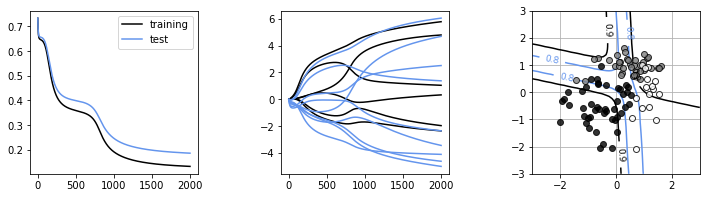

In [36]:
plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)
# 학습 오차의 표시 ---------------------------
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
# 가중치의 시간 변화 표시 ---------------------------
plt.subplot(1, 3, 2)
plt.plot(W_hist[:, :P * 3], 'black')
plt.plot(W_hist[:, P * 3:], 'cornflowerblue')
# 경계선 표시 --------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, Y_test)
P = 2
C = 3
show_FNN(W, P, C)
plt.show()

In [66]:
predit,_,_,_ = FNN(W, P, C, X_test)
correct = 0
i=0
for o,t in zip(predit,Y_test):
    print(f"output[{i}]:{o.argmax(0)} <--> target[{i}]:{t.argmax(0)}")
    correct += (o.argmax(0) == t.argmax(0)).sum().item()
    i=i+1
print(f"Accuracy:{(correct/Y_test.shape[0])*100:0.2f}%")

output[0]:2 <--> target[0]:0
output[1]:1 <--> target[1]:1
output[2]:0 <--> target[2]:0
output[3]:0 <--> target[3]:0
output[4]:1 <--> target[4]:1
output[5]:1 <--> target[5]:1
output[6]:1 <--> target[6]:1
output[7]:0 <--> target[7]:0
output[8]:0 <--> target[8]:0
output[9]:1 <--> target[9]:1
output[10]:1 <--> target[10]:1
output[11]:0 <--> target[11]:0
output[12]:1 <--> target[12]:1
output[13]:1 <--> target[13]:1
output[14]:0 <--> target[14]:0
output[15]:2 <--> target[15]:2
output[16]:1 <--> target[16]:1
output[17]:2 <--> target[17]:2
output[18]:0 <--> target[18]:0
output[19]:1 <--> target[19]:1
output[20]:2 <--> target[20]:2
output[21]:0 <--> target[21]:0
output[22]:2 <--> target[22]:2
output[23]:0 <--> target[23]:0
output[24]:0 <--> target[24]:0
output[25]:0 <--> target[25]:1
output[26]:1 <--> target[26]:1
output[27]:1 <--> target[27]:1
output[28]:1 <--> target[28]:1
output[29]:0 <--> target[29]:0
output[30]:0 <--> target[30]:0
output[31]:2 <--> target[31]:2
output[32]:0 <--> target[32]